
This workshop aims at generating Land Surface Temperature (LST) and other relevant products (NDVI,Surface Emissivity, and  Fractional vegetation cover) 
for assessing urban climates (urban heat islands) from Landsat 8 imagery using open python geospatial tools.

In this workshop we will go through the workflow using the single channel approach by Jiménez-Muñoz et. al. 2009. 

We will end by assesing the tempertures and population distribution within the city of Tallinn. 

This will give planners and policy makers an idea where people are affected by heatwaves the highest within the city. 




Some resources:
    
How to download data: https://lta.cr.usgs.gov/sites/default/files/LS_C2_Help_122020.pd

Sobrino, J.A.; Jimenez-Muoz, J.C.; Soria, G.; Romaguera, M.; Guanter, L.; Moreno, J.;
Plaza, A.; Martinez, P., "Land Surface Emissivity Retrieval From Different VNIR and TIR Sensors," in Geoscience and Remote Sensing, IEEE Transactions on , vol.46, no.2, pp.316-
327, Feb. 2008 doi: 10.1109/TGRS.2007.904834
    
J. C. Jimenez-Munoz, J. Cristobal, J. A. Sobrino, G. Soria, M. Ninyerola and X. Pons, 
"Revision of the Single-Channel Algorithm for Land Surface Temperature Retrieval From Landsat Thermal-Infrared Data," 
in IEEE Transactions on Geoscience and Remote Sensing, vol. 47, no. 1, pp. 339-349, Jan. 2009, doi: 10.1109/TGRS.2008.2007125.
        


Data: Landsat 8 image on 18.07.2020

In [1]:
#import the needed packages

import os 
import glob

import numpy as np
import pandas as pd

import rasterio as rio
from rasterio.crs import CRS

import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from geocube.api.core import make_geocube
from rasterstats import zonal_stats
from affine import Affine



import matplotlib.pyplot as plt
import matplotlib.colors as mcl

import warnings
warnings.filterwarnings('ignore')

In [2]:
#define Image folder path and necessary bands



grids = gpd.read_file('../Data/Select/grids/grids_500_utm.geojson') # 500m grids over the area of interest

pop_data = pd.read_csv('../Data/Select/grids/GRD500_2017.csv') # population per 500 m grid of Estonia


images_path = '../Data/Select/bands/' #path for folder containing all necessary bands and metadata info

mtl_path = os.path.join(images_path, '*MTL*') # metadata information



atm_params_path = os.path.join(images_path,'*atm*') # path for atmospheric parameters for calculating atm params

##################################################
#use glob to fetch the bands
b4_path = glob.glob(images_path+'*B4.tif')[0].replace('//','/')

b5_path = glob.glob(images_path+'*B5.tif')[0].replace('//','/')

b10_path = glob.glob(images_path+'*B10.tif')[0].replace('//','/')

meta_file = glob.glob(mtl_path)[0].replace('//','/')

atm_cor_params = glob.glob(atm_params_path)[0].replace('//','/')



In [3]:
grids.head(5)

,GRD_INSPIR,geometry
0,500mN65905E54250,MULTIPOLYGON Z (((712653.418 6596261.527 0.000...
1,500mN65905E54150,MULTIPOLYGON Z (((711679.175 6596629.592 0.000...
2,500mN65910E54150,MULTIPOLYGON Z (((711685.901 6596647.248 0.000...
3,500mN65905E53700,MULTIPOLYGON Z (((707405.367 6596434.607 0.000...
4,500mN65910E53700,MULTIPOLYGON Z (((707385.400 6596439.650 0.000...


In [4]:
pop_data.head(5)

,GRD_INSPIR,TOTAL
0,500mN64005E62750,0.00
1,500mN64005E62800,0.00
2,500mN64005E62850,0.00
3,500mN64010E62700,0.00
4,500mN64010E62750,0.00


In [5]:
#open and read the bands with rasterio

b4 = rio.open(b4_path).read(1)
b5 = rio.open(b5_path).read(1)
b10 = rio.open(b10_path).read(1)

transfromation = rio.open(b4_path).transform


In [6]:
#calculate NDVI

In [7]:
np.seterr(divide='ignore', invalid='ignore') #allow for the division by zero

ndvi = (b5.astype(float)-b4.astype(float))/(b5+b4) # calculate NDVI

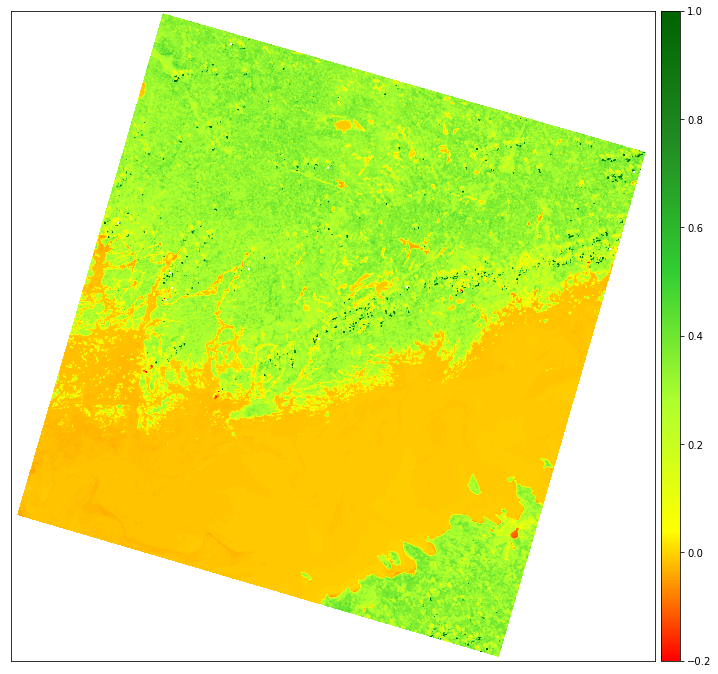

In [8]:
#visualize NDVI output

#create custom colour map
ndvi_cmap = mcl.LinearSegmentedColormap.from_list("", ["red","yellow","greenyellow","limegreen",'forestgreen','darkgreen'])


#plot ndvi
ep.plot_bands(ndvi, cmap=ndvi_cmap, cols=1, vmin=-0.2, vmax=1,scale=False)

In [9]:
#calculate fractional vegetation cover 

In [10]:
#vegprop_2=np.where(ndvi_2==-9999.0, -9999, (ndvi_2-0.2)/(0.5-0.2))

fvc = (ndvi-0.2)/(0.5-0.2)

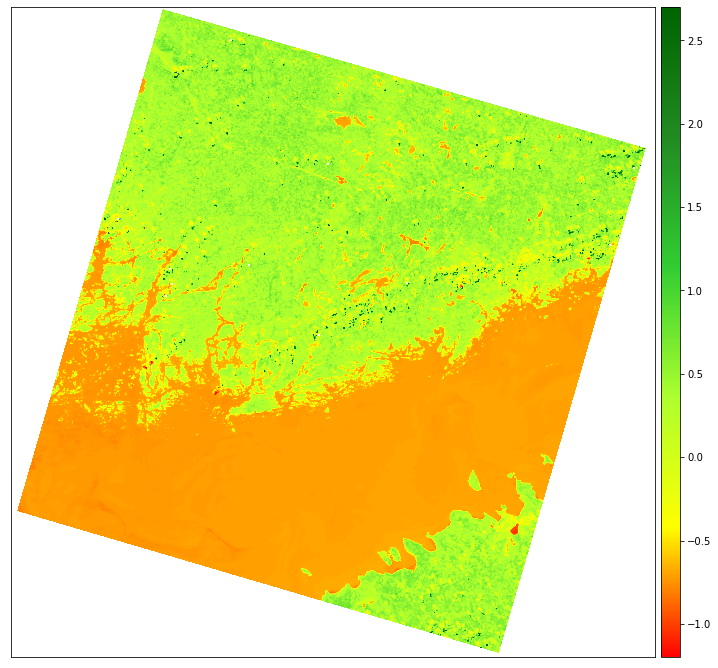

In [11]:
ep.plot_bands(fvc, cmap=ndvi_cmap, cols=1, vmin=-1.2, vmax=2.7,scale=False)

Calculte the land surface emissivity using the NDVI threshold method.

For NDVI≤ 0.2 : LSEs=0.97
ii. For 0.2<NDVI<0.5 : LSE =0.971·(1-Pv)+0.987·Pv
iii. For NDVI≥0.5 : LSE = 0.99


In [12]:

emi = []

for pix in range(len(ndvi)):
    emrow=[]
    for i in range(len(ndvi[pix])):
        if ndvi[pix][i] ==np.nan:
            emrow.append(np.nan)
        elif ndvi[pix][i]<= 0.2:
            emrow.append(0.97)
        elif 0.2<= ndvi[pix][i]>= 0.5:
            emrow.append(0.99)
        else:
            emrow.append(0.971*(1-fvc[pix][i])+(0.987*fvc[pix][i]))
    emi.append(emrow)

In [13]:
emiss = np.asarray(emi) #convert the emi to np array

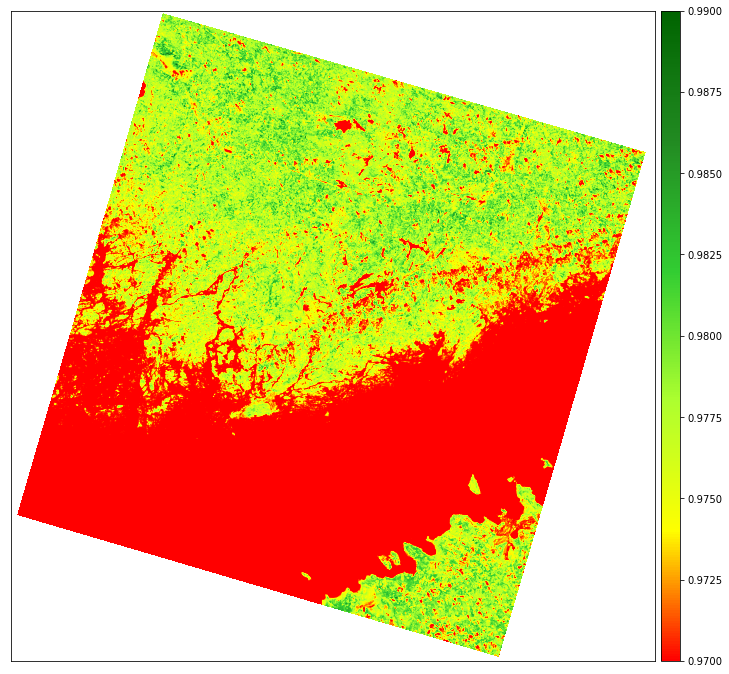

In [14]:
ep.plot_bands(emiss, cmap=ndvi_cmap, cols=1,scale=False)

In [15]:
#calculate top of the atmosphere reflectance of the thermal band

toa = (b10.astype(float)*0.0003342)+0.1 #change mult constant if not L8


In [16]:
#calculate at sensor brightness band and convert to degree cel

bt = (1321.0789 / np.log((774.8853 / toa) + 1)) - 273.15


#calculate delta and gamma -- parameters based on Plank's functions


delta = bt - ((bt*bt)/1324) 


gamma = (bt*bt)/(1324*toa) 



In [17]:
#calcultate atm functions 


atm_params = list()        
with open (atm_cor_params, "r") as file:
    for line in file:
        atm_params.append(line.strip()) 
atm_params

transmission = float(atm_params[0][atm_params[0].find(':')+1:].strip())

upwelling_radiance= float(atm_params[1][atm_params[1].find(':')+4:atm_params[1].find('W')-1].
                          strip())

downwelling_radiance= float(atm_params[2][atm_params[2].find(':')+2:atm_params[2].find('W')-1].
                            strip())



w1 = 1/transmission

w2 =(-1*downwelling_radiance) - (upwelling_radiance/transmission)

w3 = downwelling_radiance





print (transmission,upwelling_radiance,downwelling_radiance)

0.65 2.82 4.41


In [18]:
lst = gamma*((((1/emiss)*((w1*toa)+w2)) + w3))+delta

In [19]:
#create custom colour map
lst_cmap = mcl.LinearSegmentedColormap.from_list("", ["blue","lightskyblue","yellow","orange",'red'])

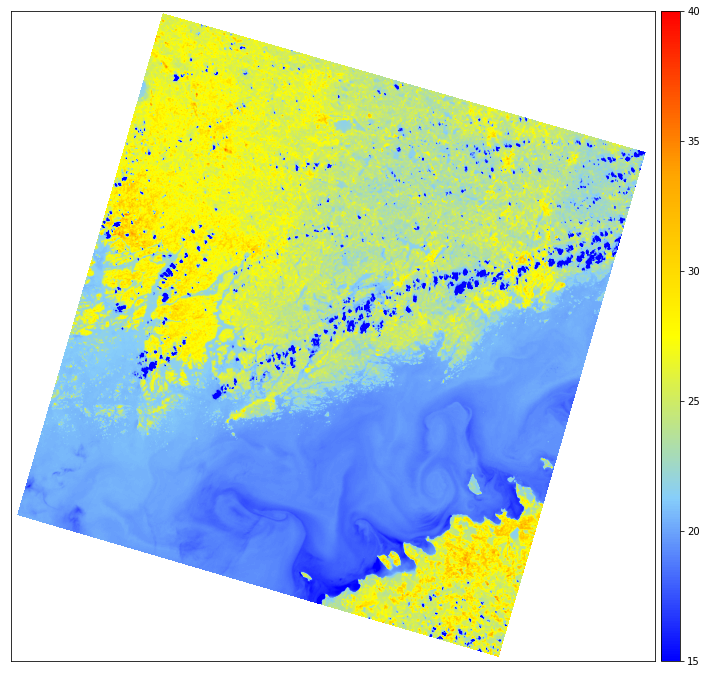

<function matplotlib.pyplot.show(*args, **kw)>

In [20]:
ep.plot_bands(lst, cmap=lst_cmap ,
              scale=False,
            vmin=15, vmax=40)
plt.show

In [21]:
grids['ndvi'] = gpd.GeoDataFrame.from_features(
                                                zonal_stats(grids,
                                                        ndvi,
                                                        stats='mean',
                                                        geojson_out=True,
                                                        affine = transfromation)
                                            )['mean'].round(2)     





grids['lst'] = gpd.GeoDataFrame.from_features(
                                                zonal_stats(grids,
                                                        lst,
                                                        stats='mean',
                                                        geojson_out=True,
                                                        affine = transfromation)
                                            )['mean'].round(2)   
    

grids = grids.to_crs('EPSG:3301')

In [22]:
grids

,GRD_INSPIR,geometry,ndvi,lst
0,500mN65905E54250,MULTIPOLYGON Z (((542646.059 6590584.074 0.000...,0.01,18.80
1,500mN65905E54150,MULTIPOLYGON Z (((541689.563 6590995.737 0.000...,0.11,27.98
2,500mN65910E54150,MULTIPOLYGON Z (((541697.079 6591013.069 0.000...,-0.01,18.95
3,500mN65905E53700,MULTIPOLYGON Z (((537411.785 6590994.060 0.000...,0.01,18.79
4,500mN65910E53700,MULTIPOLYGON Z (((537392.068 6591000.000 0.000...,0.03,22.89
...,...,...,...,...
748,500mN65860E53450,MULTIPOLYGON Z (((534701.810 6586000.000 0.000...,0.04,23.10
749,500mN65885E55200,MULTIPOLYGON Z (((552500.000 6588890.198 0.000...,0.29,28.03
750,500mN65925E55150,MULTIPOLYGON Z (((551865.550 6593000.000 0.000...,0.26,23.42
751,500mN65865E54200,MULTIPOLYGON Z (((542000.000 6586500.000 0.000...,0.16,30.81


In [23]:
#pop density

In [24]:

grids['area'] = grids.area.round(2) #calulate the area of each grid


grids['pop'] = grids.merge(pop_data,on='GRD_INSPIR')['TOTAL']


#grids['pop_dens'] = grids['pop'] /grids['area']

In [26]:

    
cube = make_geocube(vector_data=grids, resolution=(500, 500))
    
    
cube.rio.to_raster('test1.tif')